In [89]:
import numpy as np
from data_generation import *
import cvxpy as cp
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [79]:
def offdiag_l1_norm(M):
    """Compute the L1 norm of off-diagonal entries."""
    return np.sum(np.abs(M - np.diag(np.diag(M))))

def soft_threshold_offdiag(M, lam):
    """
    Soft-threshold only the off-diagonal entries of M by lam.
    Diagonal entries are unchanged.
    """
    diag_part = np.diag(np.diag(M))
    offdiag_part = M - diag_part
    offdiag_thresh = np.sign(offdiag_part) * np.maximum(np.abs(offdiag_part) - lam, 0.0)
    return diag_part + offdiag_thresh

def negative_loglike_grad(Theta, S, n):
    """
    Gradient of the negative log-likelihood term:
      n * [ - log det(Theta) + trace(S * Theta) ]
    w.r.t. Theta is:
      n * [ - inv(Theta) + S ]
    """
    inv_Theta = np.linalg.inv(Theta)
    return n * (-inv_Theta + S)

def psi_l1(X):
    """Elementwise L1 norm."""
    return np.sum(np.abs(X))

def psi_group_l2(X):
    """Group-lasso norm: sum of column L2 norms."""
    val = 0.0
    for j in range(X.shape[1]):
        col = X[:, j]
        val += np.linalg.norm(col)
    return val

def psi_laplacian(X):
    """
    'Smooth' penalty = 0.5 * ||X||^2_F.
    Factor 0.5 is convenient for its gradient.
    """
    return 0.5 * np.sum(X * X)

def psi_grad(X, psi_type):
    """
    Returns the gradient (or subgradient) of psi(X) for
    the specified psi_type in {"l1", "group_l2", "laplacian"}.
    """
    if psi_type == "l1":
        # subgradient for elementwise L1 = sign(X)
        return np.sign(X)
    elif psi_type == "group_l2":
        # each column is a 'group'
        G = np.zeros_like(X)
        for j in range(X.shape[1]):
            col = X[:, j]
            norm_col = np.linalg.norm(col)
            if norm_col > 1e-12:
                G[:, j] = col / norm_col
        return G
    elif psi_type == "laplacian":
        # derivative of 0.5 * ||X||^2_F is X
        return X
    else:
        raise NotImplementedError(f"Unknown psi_type={psi_type}.")


# -------------------------------------------------------------------
# Main solver function
# -------------------------------------------------------------------
def solve_tvgl(
    S_list,
    n_list,
    lam=0.1,
    beta=0.1,
    psi_type="l1",
    step_size=1e-3,
    max_iter=50,
    tol=1e-4
):
    """
    Solves the Time-Varying Graphical Lasso problem via proximal gradient:
      min_{Theta_1,...,Theta_T}
        sum_{i=1..T} [ -n_i ( log det(Theta_i) - trace(S_i * Theta_i) )
                       + lam * ||Theta_i||_{od,1} ]
        + beta * sum_{i=2..T} psi( Theta_i - Theta_{i-1} )
    
    Parameters
    ----------
    S_list : list of np.ndarray
        Empirical covariances, one for each time i=1..T.
    n_list : list of int
        Sample sizes for each time i=1..T.
    lam : float
        Penalty weight for L1 off-diagonal terms.
    beta : float
        Penalty weight for temporal difference.
    psi_type : str
        Type of temporal penalty: {"l1", "group_l2", "laplacian"}.
    step_size : float
        Step size for gradient descent.
    max_iter : int
        Max number of iterations.
    tol : float
        Stopping threshold for Frobenius norm difference across Theta updates.
    
    Returns
    -------
    Thetas : list of np.ndarray
        The estimated precision matrices (Theta_i for i=1..T).
    """

    T = len(S_list)
    p = S_list[0].shape[0]
    Thetas = [np.eye(p) for _ in range(T)]  # initialize to identity

    for iteration in range(max_iter):
        old_Thetas = [Th.copy() for Th in Thetas]

        # Compute gradient for each Theta_i
        grad_list = []
        for i in range(T):
            g = negative_loglike_grad(Thetas[i], S_list[i], n_list[i])

            # Add derivative from beta * psi(Theta_i - Theta_{i-1})
            if i > 0:
                diff_fwd = Thetas[i] - Thetas[i-1]
                g += beta * psi_grad(diff_fwd, psi_type)

            # Subtract derivative from beta * psi(Theta_{i+1} - Theta_i)
            if i < T - 1:
                diff_bwd = Thetas[i+1] - Thetas[i]
                g -= beta * psi_grad(diff_bwd, psi_type)

            grad_list.append(g)

        # Gradient step + prox for each Theta_i
        for i in range(T):
            Theta_new = Thetas[i] - step_size * grad_list[i]
            # off-diagonal soft thresholding
            Theta_new = soft_threshold_offdiag(Theta_new, lam * step_size)
            # symmetrize
            Theta_new = 0.5 * (Theta_new + Theta_new.T)
            # small shift on diagonal to help positivity
            Theta_new += 1e-7 * np.eye(p)
            Thetas[i] = Theta_new

        # Check convergence
        max_diff = 0.0
        for i in range(T):
            diff_norm = np.linalg.norm(Thetas[i] - old_Thetas[i], ord='fro')
            if diff_norm > max_diff:
                max_diff = diff_norm

        if max_diff < tol:
            print(f"Converged at iteration {iteration+1}, update norm={max_diff:.2e}")
            break

    return Thetas

In [91]:
N = 1000  
d = 6    
T = 10     
t_shift = 5  
delta = 0.2 

data, covariances =generate_time_varying_gaussian_data_with_perturbation(N, d, T, t_shift, delta)

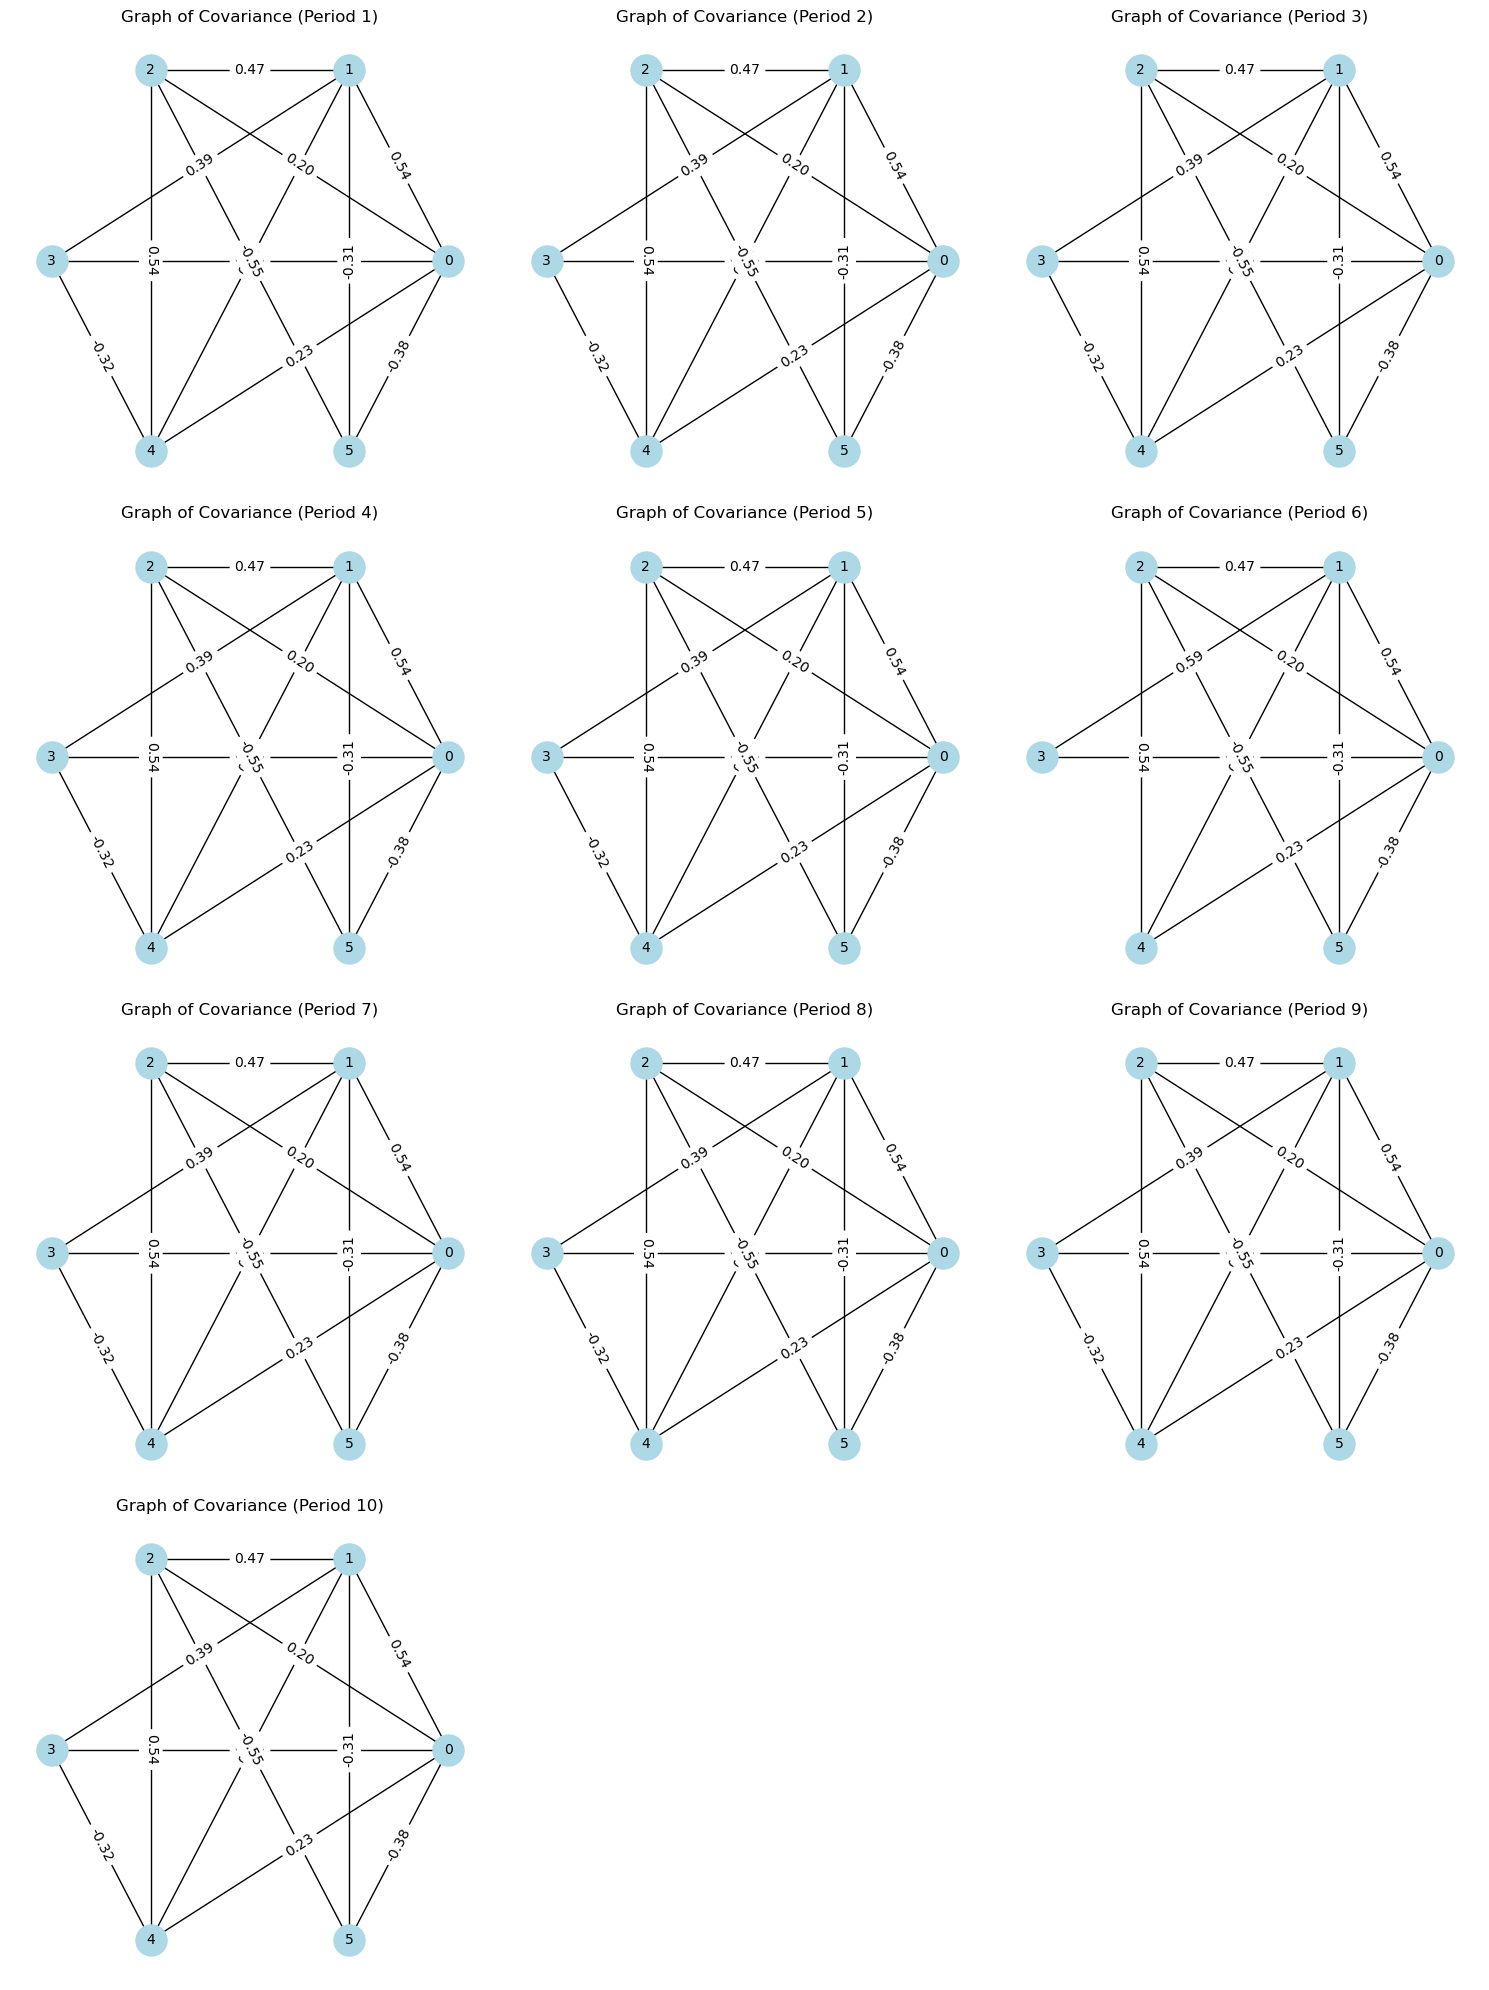

In [92]:
plot_graph(covariances, threshold=0.2)

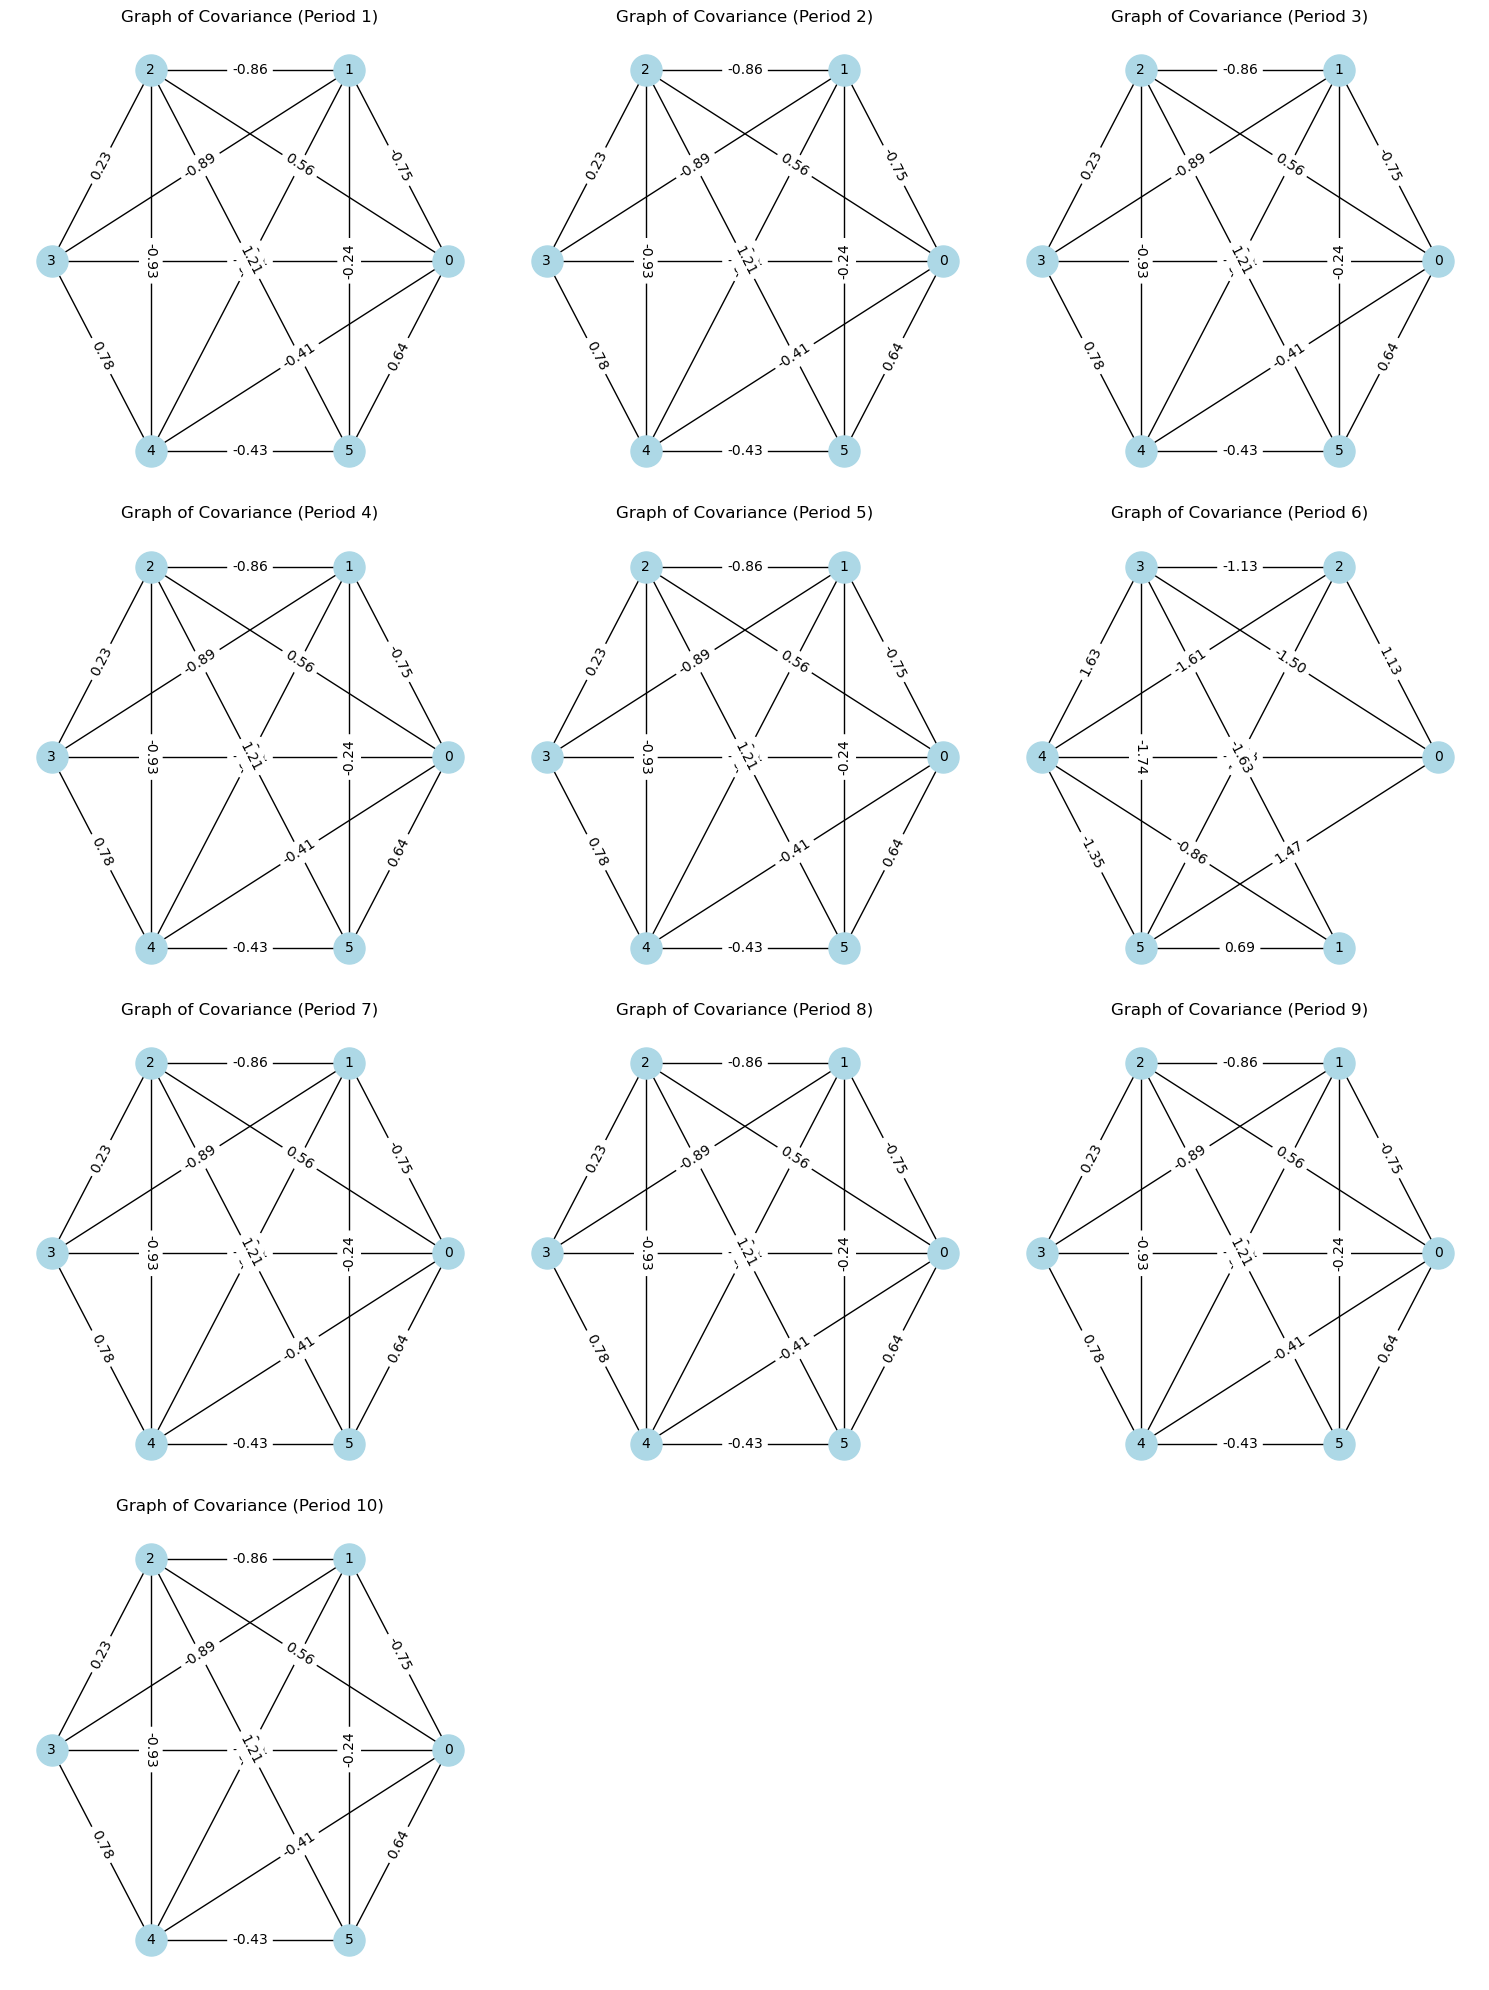

In [93]:

inverse_covariances = [inv(cov) for cov in covariances]
plot_graph(inverse_covariances, threshold=0.2)

In [94]:
grouped_data = data.groupby('Period')

S_list = []
for period, group in grouped_data:

    features = group.drop(columns=['Period']).values 

    n = features.shape[0]

    XtX_n = np.dot(features.T, features) / n
    
    S_list.append(XtX_n)

# Output the list of matrices
print(f"Generated {len(S_list)} empirical covariance matrices (X^T X / n).")

Generated 10 empirical covariance matrices (X^T X / n).


In [95]:
n_list=[100 for _ in range(len(S_list))]

Thetas_est = solve_tvgl(
    S_list, 
    n_list,
    lam=0.1,
    beta=0.1,
    psi_type="laplacian",
    step_size=1e-3,
    max_iter=100,
    tol=1e-5
)

# Print results
print("Final Thetas:")
for idx, Theta in enumerate(Thetas_est, 1):
    print(f"\nTheta_{idx}:\n{Theta}")


Final Thetas:

Theta_1:
[[ 1.52841475 -0.42203247  0.30464101 -0.51668033 -0.28873317  0.35499481]
 [-0.42203247  1.91680547 -0.63757734 -0.52003779 -0.22182926  0.02921164]
 [ 0.30464101 -0.63757734  1.96798388 -0.00476297 -0.7084418   0.73100622]
 [-0.51668033 -0.52003779 -0.00476297  1.67935187  0.44186223  0.13890568]
 [-0.28873317 -0.22182926 -0.7084418   0.44186223  1.54724361 -0.19919683]
 [ 0.35499481  0.02921164  0.73100622  0.13890568 -0.19919683  1.57384065]]

Theta_2:
[[ 1.38097656 -0.64817999  0.30000868 -0.10681615 -0.20791187  0.341481  ]
 [-0.64817999  1.92648532 -0.80008694 -0.75293731 -0.37119788  0.04301789]
 [ 0.30000868 -0.80008694  1.99413219  0.22340777 -0.61397527  0.71241344]
 [-0.10681615 -0.75293731  0.22340777  1.44025059  0.56357029 -0.1183851 ]
 [-0.20791187 -0.37119788 -0.61397527  0.56357029  1.60554072 -0.21465544]
 [ 0.341481    0.04301789  0.71241344 -0.1183851  -0.21465544  1.4492451 ]]

Theta_3:
[[ 1.45132312 -0.57123752  0.24467628 -0.31389534 -0.1

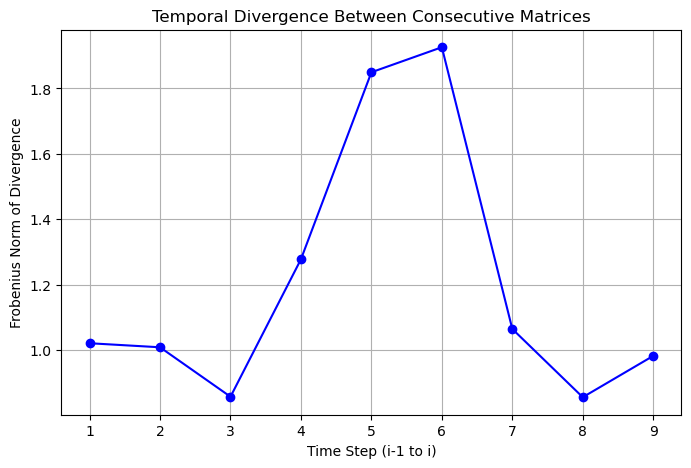

In [97]:

temporal_divergence = [
    np.linalg.norm(Thetas_est[i] - Thetas_est[i-1], ord='fro') for i in range(1, T)
]

plt.figure(figsize=(8, 5))
plt.plot(range(1, T), temporal_divergence, marker='o', linestyle='-', color='b')
plt.title("Temporal Divergence Between Consecutive Matrices")
plt.xlabel("Time Step (i-1 to i)")
plt.ylabel("Frobenius Norm of Divergence")
plt.grid(True)
plt.show()


In [98]:
import numpy as np
import cvxpy as cp


# Regularization parameters
lambda_ = 0.01
beta = 2

# Define variables
Thetas = [cp.Variable((d, d), symmetric=True) for _ in range(T)]

# Constraints
constraints = [Theta >> 0 for Theta in Thetas]  # Ensure SPD matrices

# Objective function
log_det_terms = sum(cp.log_det(Theta) - cp.trace(S_list[i] @ Theta) for i, Theta in enumerate(Thetas))
sparsity_terms = sum(cp.norm(Theta - cp.diag(cp.diag(Theta)), 1) for Theta in Thetas)

# Laplacian penalty: sum of squared Frobenius norms
smoothness_terms = sum(cp.norm(Thetas[i] - Thetas[i-1], "fro")**2 for i in range(1, T))

# Full objective function
objective = cp.Maximize(log_det_terms - lambda_ * sparsity_terms - beta * smoothness_terms)

# Problem setup
problem = cp.Problem(objective, constraints)

# Solve using interior-point method
problem.solve(solver=cp.SCS, verbose=True)

# Output results
for i, Theta in enumerate(Thetas):
    print(f"Theta[{i}] = \n{Theta.value}")


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 18 04:23:23 PM: Your problem has 360 variables, 360 constraints, and 0 parameters.
(CVXPY) Jan 18 04:23:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 18 04:23:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 18 04:23:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 18 04:23:23 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 18 04:23:23 PM: Compiling problem (target solver=SCS).
(C

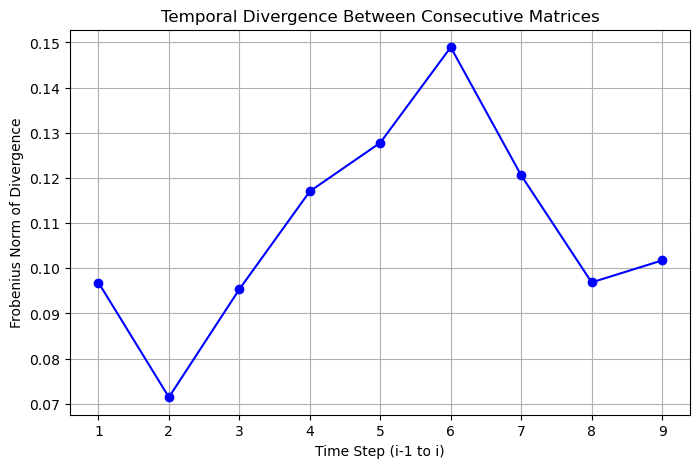

In [99]:

# Compute temporal divergence (Frobenius norm of differences between consecutive matrices)
temporal_divergence = [
    np.linalg.norm(Thetas[i].value - Thetas[i-1].value, ord='fro') for i in range(1, T)
]

# Plot temporal divergence
plt.figure(figsize=(8, 5))
plt.plot(range(1, T), temporal_divergence, marker='o', linestyle='-', color='b')
plt.title("Temporal Divergence Between Consecutive Matrices")
plt.xlabel("Time Step (i-1 to i)")
plt.ylabel("Frobenius Norm of Divergence")
plt.grid(True)
plt.show()
